In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.ascontiguousarray(np.vstack((X_train,X_test)).reshape(-1,28,28,1))
y_train=np.ascontiguousarray(np.hstack((y_train,y_test)))

In [4]:
Y=np.zeros((y_train.size,y_train.max()+1),dtype=np.float32)
Y[np.arange(y_train.size),y_train]=1

## Add path to this repo below https://github.com/ShivamShrirao/dnn_from_scratch

In [5]:
import sys
sys.path.append("../dnn_from_scratch")

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 861
Seed: 173


In [7]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100+10))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 110)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        696192
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 con

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,11)))
    model.add(BatchNormalization())
    model.add(dropout(0.3))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.3))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 11)         echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        3200
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 14, 14, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
5 Batch

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [10]:
noise=np.random.randn(64,100+10).astype(np.float32)
gen=g.predict(noise)

In [11]:
X_train.shape,Y.shape

((70000, 28, 28, 1), (70000, 10))

In [12]:
def gen_sample():
    cndtn=Y[np.random.randint(0,Y.shape[0],1)]
    print()
    print(cndtn[0].argmax())
    noise=np.hstack((np.random.randn(1,100),cndtn)).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen.reshape(28,28)+1)/2, cmap='Greys')
    plt.show()

In [13]:
def run(batch_size=128):
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        fake_labels=Y[np.random.randint(0,Y.shape[0],batch_size)]
        noise=np.hstack((np.random.randn(batch_size,100),fake_labels)).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        idxs=np.random.randint(low=0,high=X_train.shape[0],size=batch_size)
        real_images=X_train[idxs]
        real_labels=Y[idxs]
        # Train discriminator
#         y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
#         y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        real_labels=np.expand_dims(real_labels, axis=1)
        real_labels=np.expand_dims(real_labels, axis=1)
        real_labels=np.tile(real_labels,[1,28,28,1])
        real_images=np.concatenate((real_images,real_labels),axis=3)

        fake_labels=np.expand_dims(fake_labels, axis=1)
        fake_labels=np.expand_dims(fake_labels, axis=1)
        fake_labels=np.tile(fake_labels,[1,28,28,1])
        generated_images=np.concatenate((generated_images,fake_labels),axis=3)

        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
                
        # Train generator
        gen_labels=Y[np.random.randint(0,Y.shape[0],batch_size)]
        noise=np.hstack((np.random.randn(batch_size,100),gen_labels)).astype(np.float32)
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        gen_labels=np.expand_dims(gen_labels, axis=1)
        gen_labels=np.expand_dims(gen_labels, axis=1)
        gen_labels=np.tile(gen_labels,[1,28,28,1])
        gout=np.concatenate((gout,gen_labels),axis=3)

        dout,err=d.not_train_on_batch(gout,y_gen)

        err=err[:,:,:,:1]

        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%30:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

In [ ]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(256)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

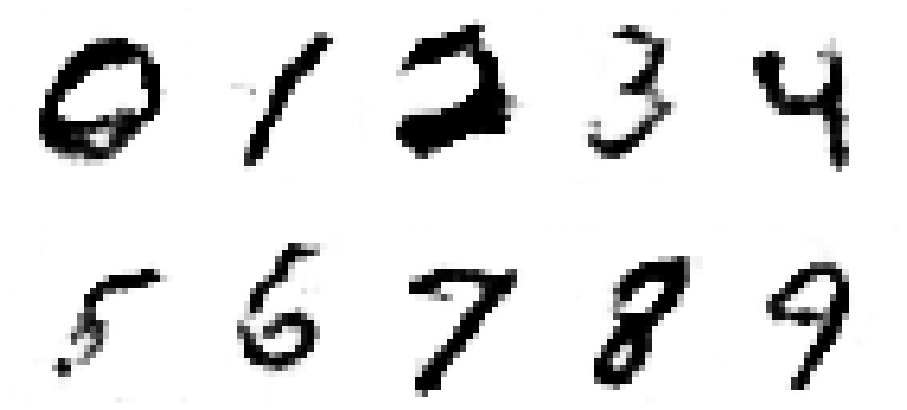

In [63]:
fig, ax = plt.subplots(nrows=2,ncols=5,figsize=[16,8],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
noise=np.hstack((np.random.randn(10,100),np.eye(10))).astype(np.float32)
# noise=np.random.randn(25,10).astype(np.float32)
gen = g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow((gen[i].squeeze()+1)/2, cmap='Greys')

In [255]:
def GANgen(num):
    cond=np.zeros((1,10))
    cond[0,num]=1
    noise=np.hstack((np.random.randn(1,100),cond)).astype(np.float32)
    gen=g.predict(noise)
#     plt.imshow((gen.reshape(28,28)+1)/2, cmap='Greys')
#     plt.show()
    return gen

In [161]:
isEven=Sequential()

In [ ]:
isEven.add(conv2d(num_kernels=8,kernel_size=3,activation=functions.relu,input_shape=(28,28,1)))
isEven.add(max_pool())
isEven.add(dropout(0.2))
isEven.add(conv2d(num_kernels=16,kernel_size=3,activation=functions.relu))
isEven.add(max_pool())
isEven.add(dropout(0.3))
isEven.add(flatten())
isEven.add(dense(256,activation=functions.relu))
isEven.add(dropout(0.4))
isEven.add(dense(1,activation=functions.sigmoid))

In [163]:
isEven.compile()

In [197]:
y_training=(y_train%2==0).astype(np.float32).reshape(-1,1)
y_testing=(np.asarray(y_test)%2==0).astype(np.float32).reshape(-1,1)
X_test=X_test.reshape(-1,28,28,1)

In [199]:
isEven.fit(X_train,y_training,batch_size=128,epochs=1,validation_data=(X_test,y_testing))

EPOCH: 1 / 1
Progress:  70016 / 70000  - 0s - 2.2s/sample - loss: 0.7725 - accuracy: 1.0000      . ..      .
Epoch time: 67.022
Validation Accuracy: 1.0 - val_loss: 0.1709


In [260]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 11)         echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        3200
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 14, 14, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
5 Batch

In [261]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 110)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        696192
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 con

In [259]:
isEven.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 28, 28, 8)          relu             80
__________________________________________________________________________________________
2 max_pool(max_pool)      (None, 14, 14, 8)          echo             0
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 8)          echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 14, 14, 16)         relu             1168
__________________________________________________________________________________________
5 max_pool(m

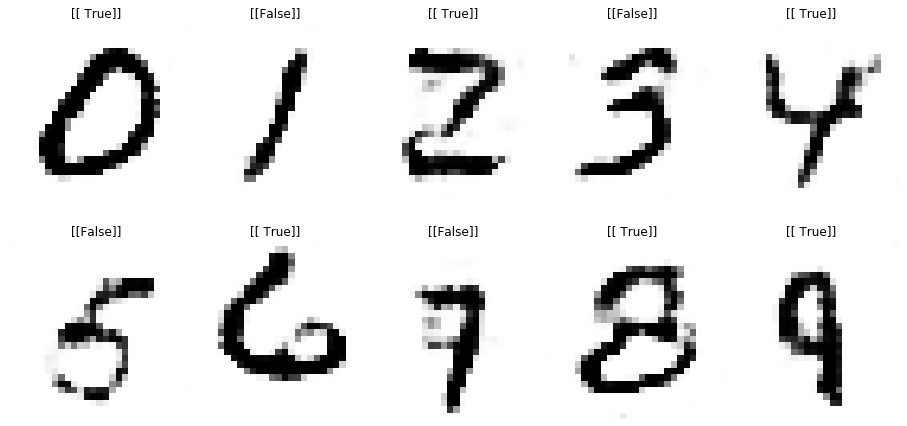

In [272]:
fig, ax = plt.subplots(nrows=2,ncols=5,figsize=[16,8],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    gen=GANgen(abs(i)%10)
    axi.set_title(isEven.predict(gen)>0.5)
    axi.imshow((gen.squeeze()+1)/2, cmap='Greys')

In [68]:
# g.save_weights("g.w8s")
# d.save_weights("d.w8s")